In [1]:
!pip install kaggle

In [2]:
import os
os.mkdir('/content/kaggle')

In [3]:
import json
token = {"username":"prabhatale","key":"a17630a4aed5ea80bd008176986b2036"}
with open('/content/kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [6]:
!cp /content/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [7]:
!kaggle config set -n path -v{/content}

- path is now set to: {/content}


In [8]:
!chmod 600 /root/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d prashant268/chest-xray-covid19-pneumonia -p /content

100% 1.65G/1.65G [00:53<00:00, 27.2MB/s]
100% 1.65G/1.65G [00:53<00:00, 33.1MB/s]


In [10]:
import zipfile
archive1 = zipfile.ZipFile('/content/chest-xray-covid19-pneumonia.zip')
archive1.extractall('/content')

In [11]:
xray_types = ['COVID19','NORMAL','PNEUMONIA']

In [12]:
for category in xray_types:
  print("There are {} {} images".format(len(os.listdir(os.path.join('/content/Data/train',category))),category))

There are 460 COVID19 images
There are 1266 NORMAL images
There are 3418 PNEUMONIA images


In [13]:
for category in xray_types:
  print("There are {} {} images".format(len(os.listdir(os.path.join('/content/Data/test',category))),category))

There are 116 COVID19 images
There are 317 NORMAL images
There are 855 PNEUMONIA images


In [14]:
# Image Visualization


In [15]:
def image_paths_for_visualizaton(base_data_dir,split_type,no_of_samples):
  image_paths = []
  path = os.path.join(base_data_dir,split_type)
  for category in xray_types:
    new_path = os.path.join(path,category)
    i = 1
    for img in os.listdir(new_path):
      if i > no_of_samples:
        break
      image_paths.append(os.path.join(new_path,img))
      i+= 1
  return image_paths

In [16]:
import matplotlib.pyplot as plt
import cv2
def visualize_images(imagepaths,rows,cols):
  fig = plt.figure(figsize=(20,20))
  rows = rows
  cols = cols
  for i in range(1,rows*cols+1):
    fig.add_subplot(rows,cols,i)
    img_array = cv2.imread(imagepaths[i-1])
    fig.subplots_adjust(hspace=1)
    plt.imshow(cv2.cvtColor(img_array,cv2.COLOR_BGR2RGB))
    plt.xlabel(imagepaths[i-1].split('/')[-2])
  plt.show()

In [17]:
train_image_paths = image_paths_for_visualizaton(base_data_dir='/content/Data',split_type='train',
                                                 no_of_samples=10)
print(train_image_paths)
print(len(train_image_paths))

['/content/Data/train/COVID19/COVID19(296).jpg', '/content/Data/train/COVID19/COVID19(469).jpg', '/content/Data/train/COVID19/COVID19(89).jpg', '/content/Data/train/COVID19/COVID19(109).jpg', '/content/Data/train/COVID19/COVID19(559).jpg', '/content/Data/train/COVID19/COVID19(453).jpg', '/content/Data/train/COVID19/COVID19(232).jpg', '/content/Data/train/COVID19/COVID19(491).jpg', '/content/Data/train/COVID19/COVID19(242).jpg', '/content/Data/train/COVID19/COVID19(307).jpg', '/content/Data/train/NORMAL/NORMAL(133).jpg', '/content/Data/train/NORMAL/NORMAL(96).jpg', '/content/Data/train/NORMAL/NORMAL(555).jpg', '/content/Data/train/NORMAL/NORMAL(1536).jpg', '/content/Data/train/NORMAL/NORMAL(37).jpg', '/content/Data/train/NORMAL/NORMAL(562).jpg', '/content/Data/train/NORMAL/NORMAL(517).jpg', '/content/Data/train/NORMAL/NORMAL(1042).jpg', '/content/Data/train/NORMAL/NORMAL(1376).jpg', '/content/Data/train/NORMAL/NORMAL(530).jpg', '/content/Data/train/PNEUMONIA/PNEUMONIA(692).jpg', '/conte

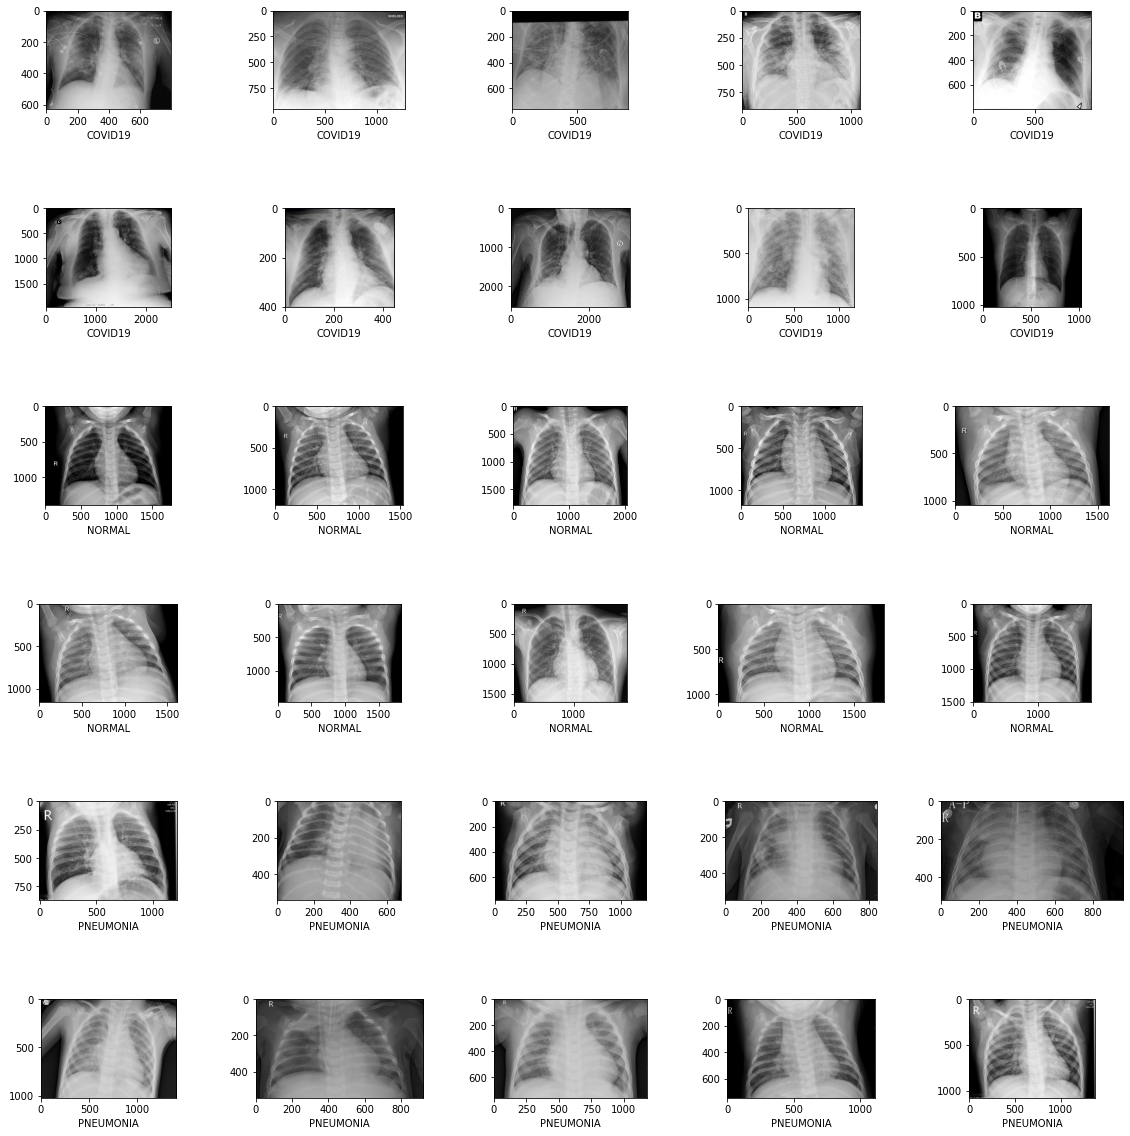

In [18]:
visualize_images(train_image_paths,rows=6,cols=5)

In [19]:
test_image_paths = image_paths_for_visualizaton(base_data_dir='/content/Data',split_type='test',
                                                 no_of_samples=10)
print(test_image_paths)
print(len(test_image_paths))

['/content/Data/test/COVID19/COVID19(562).jpg', '/content/Data/test/COVID19/COVID19(449).jpg', '/content/Data/test/COVID19/COVID19(64).jpg', '/content/Data/test/COVID19/COVID19(207).jpg', '/content/Data/test/COVID19/COVID19(198).jpg', '/content/Data/test/COVID19/COVID19(382).jpg', '/content/Data/test/COVID19/COVID19(478).jpg', '/content/Data/test/COVID19/COVID19(164).jpg', '/content/Data/test/COVID19/COVID19(490).jpg', '/content/Data/test/COVID19/COVID19(433).jpg', '/content/Data/test/NORMAL/NORMAL(1384).jpg', '/content/Data/test/NORMAL/NORMAL(877).jpg', '/content/Data/test/NORMAL/NORMAL(988).jpg', '/content/Data/test/NORMAL/NORMAL(1170).jpg', '/content/Data/test/NORMAL/NORMAL(1291).jpg', '/content/Data/test/NORMAL/NORMAL(1204).jpg', '/content/Data/test/NORMAL/NORMAL(847).jpg', '/content/Data/test/NORMAL/NORMAL(1327).jpg', '/content/Data/test/NORMAL/NORMAL(554).jpg', '/content/Data/test/NORMAL/NORMAL(1431).jpg', '/content/Data/test/PNEUMONIA/PNEUMONIA(3821).jpg', '/content/Data/test/PN

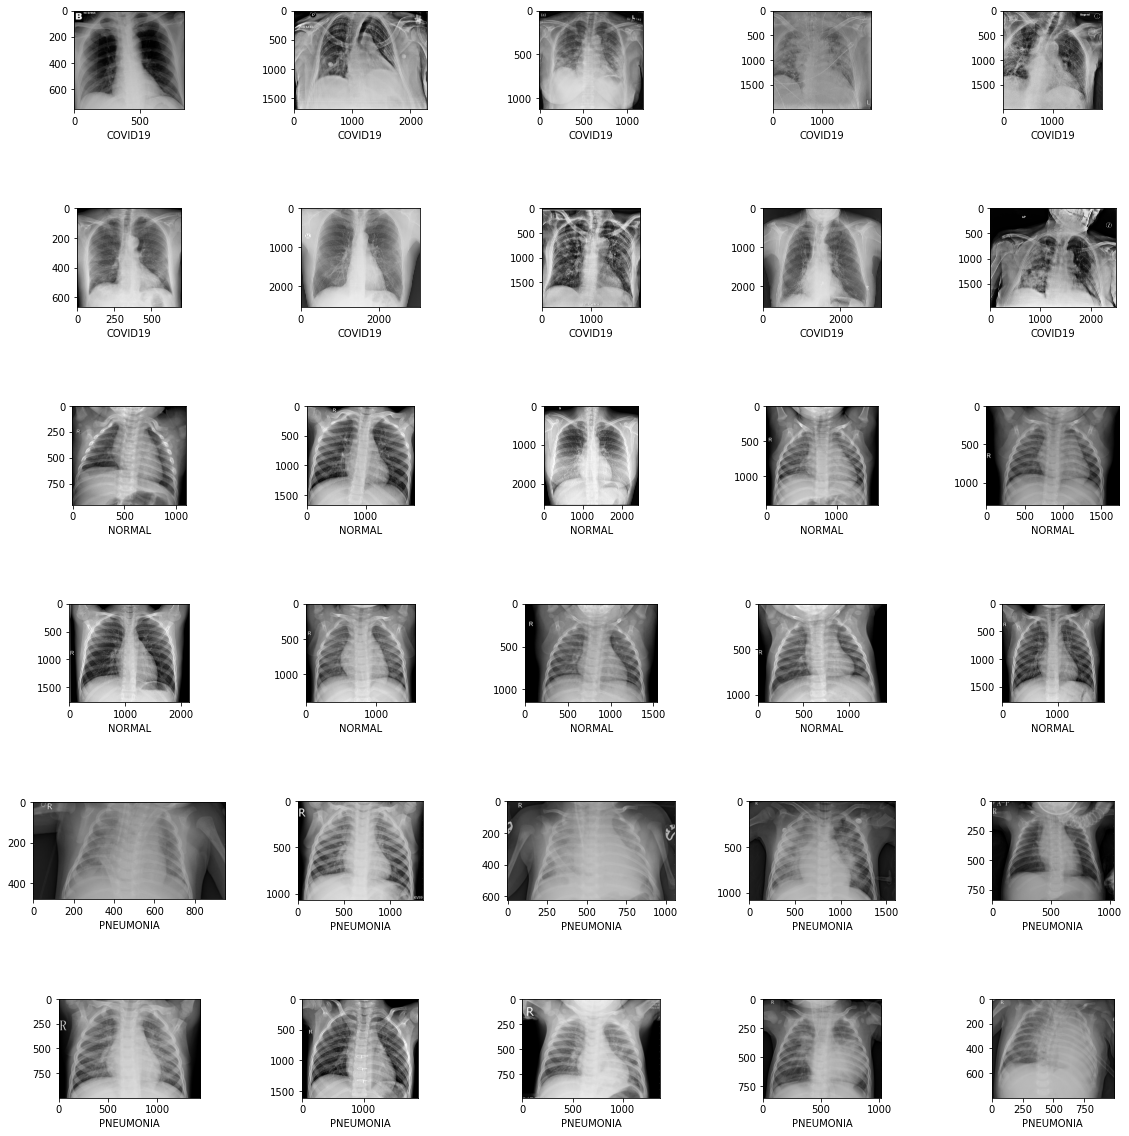

In [20]:
visualize_images(test_image_paths,rows=6,cols=5)

In [21]:
base_dir = '/content/Data'
train_dir = '/content/Data/train'
valid_dir = '/content/Data/test'

In [22]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dropout,Flatten,Dense
from keras.applications.xception import Xception
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from keras.optimizers import Adam
from keras.models import Model

Using TensorFlow backend.


In [23]:
train_datagen = ImageDataGenerator(rescale= 1/255.0,horizontal_flip=True,rotation_range=15,
                                   brightness_range=(0.4,1.4))

valid_datagen = ImageDataGenerator(rescale=1/255.0)

In [24]:
train_generator = train_datagen.flow_from_directory(directory=train_dir,target_size=(350,350),
                                                    color_mode='rgb',class_mode='categorical',
                                                    batch_size=25,shuffle=True)

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,target_size=(350,350),color_mode='rgb',
                                                    class_mode='categorical',batch_size=25,shuffle=True)

Found 5144 images belonging to 3 classes.
Found 1288 images belonging to 3 classes.


In [25]:
xception = Xception(weights='imagenet',include_top=False,input_shape=(350,350,3))

83689472/83683744 [==============================] - 8s 0us/step


In [26]:
xception.trainable = False

In [27]:
# # Let's take a look to see how many layers are in the base model
# print("Number of layers in the base model: ", len(resnet.layers))

# # Fine-tune from this layer onwards
# fine_tune_at = 170

# # Freeze all the layers before the `fine_tune_at` layer
# for layer in resnet.layers[:fine_tune_at]:
#   layer.trainable =  False

In [28]:
output = Flatten()(xception.output)
output = Dropout(0.25)(output)
prediction = Dense(3,activation='softmax')(output)

In [29]:
model = Model(inputs = xception.input,outputs = prediction)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 350, 350, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 174, 174, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 174, 174, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 174, 174, 32) 0           block1_conv1_bn[0][0]            
____________________________________________________________________________________________

In [30]:
# tell the model what cost and optimization method to use
model.compile(
  loss='categorical_crossentropy',
  optimizer=Adam(
    learning_rate=0.00001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07
),
  metrics=['accuracy']
)

In [31]:
import os
os.mkdir('/content/model_weights/')

In [32]:
model_checkpoint = ModelCheckpoint('./model_weights/covid19few_model_{epoch:02d}-{val_accuracy:.6f}.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True,save_weights_only=True)


In [33]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // 25,
    validation_data = valid_generator, 
    validation_steps = valid_generator.samples // 25,
    epochs = 30,
    callbacks=[model_checkpoint])

Epoch 1/30
205/205 [==============================] - 405s 2s/step - loss: 0.3302 - accuracy: 0.8771 - val_loss: 0.3694 - val_accuracy: 0.9184

Epoch 00001: val_loss improved from inf to 0.36936, saving model to ./model_weights/covid19few_model_01-0.918431.h5
Epoch 2/30
205/205 [==============================] - 382s 2s/step - loss: 0.1513 - accuracy: 0.9496 - val_loss: 0.3090 - val_accuracy: 0.9485

Epoch 00002: val_loss improved from 0.36936 to 0.30898, saving model to ./model_weights/covid19few_model_02-0.948535.h5
Epoch 3/30
205/205 [==============================] - 381s 2s/step - loss: 0.1113 - accuracy: 0.9609 - val_loss: 0.1127 - val_accuracy: 0.9359

Epoch 00003: val_loss improved from 0.30898 to 0.11269, saving model to ./model_weights/covid19few_model_03-0.935867.h5
Epoch 4/30
205/205 [==============================] - 381s 2s/step - loss: 0.0941 - accuracy: 0.9664 - val_loss: 0.3917 - val_accuracy: 0.9462

Epoch 00004: val_loss did not improve from 0.11269
Epoch 5/30
205/20

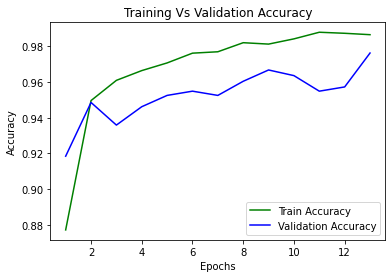

In [40]:
import matplotlib.pyplot as plt
train_accuracy = history.history['accuracy'][:13]
validation_accuracy = history.history['val_accuracy'][:13]
epochs = range(1,14)
plt.plot(epochs,train_accuracy,'g',label='Train Accuracy')
plt.plot(epochs,validation_accuracy,'b',label='Validation Accuracy')
plt.title('Training Vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

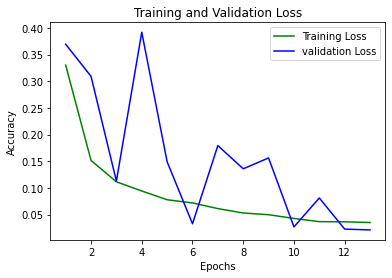

In [39]:
import matplotlib.pyplot as plt
train_loss = history.history['loss'][:13]
val_loss = history.history['val_loss'][:13]
epochs = range(1,14)
plt.plot(epochs,train_loss,'g', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [41]:
# serialize model to JSON
model_json = model.to_json()
with open("covid19few_classification_model.json", "w") as json_file:
    json_file.write(model_json)

In [42]:
from keras.models import model_from_json
# load json and create model
json_file = open('/content/covid19few_classification_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model_weights/covid19few_model_13-0.976247.h5")
print("Loaded model from disk")

Loaded model from disk


In [43]:
from keras.preprocessing import image
import numpy as np
def check_xray(path,chest_xray_type):
  predictor = {}
  path= os.path.join(path,chest_xray_type)
  for img in os.listdir(path):
    img = image.load_img(os.path.join(path,img),target_size=(350,350))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = img / 255.0
    prediction = loaded_model.predict(img)
    prediction_class  = np.argmax(prediction)
    result = xray_types[prediction_class]
    if result not in predictor:
      predictor[result] = 1
    else:
      predictor[result] += 1
  return predictor

In [45]:
for category in xray_types:
  print("There are {} {} images".format(len(os.listdir(os.path.join('/content/Data/train',category))),category))

There are 460 COVID19 images
There are 1266 NORMAL images
There are 3418 PNEUMONIA images


In [46]:
for category in xray_types:
  print("There are {} {} images".format(len(os.listdir(os.path.join('/content/Data/test',category))),category))

There are 116 COVID19 images
There are 317 NORMAL images
There are 855 PNEUMONIA images


In [49]:
check_xray(path=valid_dir,chest_xray_type=xray_types[2])

{'NORMAL': 23, 'PNEUMONIA': 832}

In [50]:
(1251/1288)*100

97.12732919254658

In [59]:
from keras.preprocessing import image
import numpy as np
def get_actual_labels(base_dir_path,split_type,categories):
  actual_labels = []
  path= os.path.join(base_dir_path,split_type)
  for category in categories:
    new_path = os.path.join(path,category)
    for img in os.listdir(new_path):
      actual_class= categories.index(category)
      actual_labels.append(actual_class)
  return actual_labels

In [63]:
from keras.preprocessing import image
import numpy as np
def get_prediction_labels(base_dir_path,split_type,categories):
  prediction_labels = []
  path= os.path.join(base_dir_path,split_type)
  for category in categories:
    new_path = os.path.join(path,category)
    for img in os.listdir(new_path):
      img = image.load_img(os.path.join(new_path,img),target_size=(350,350))
      img = image.img_to_array(img)
      img = np.expand_dims(img,axis=0)
      img = img / 255.0
      prediction = loaded_model.predict(img)
      prediction_class  = np.argmax(prediction)
      prediction_labels.append(prediction_class)
  return prediction_labels

In [64]:
actual_labels = get_actual_labels(base_dir_path=base_dir,split_type='test',categories=xray_types)
print(actual_labels)
print(len(actual_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [65]:
prediction_labels = get_prediction_labels(base_dir_path=base_dir,split_type='test',categories=xray_types)
print(prediction_labels)
print(len(prediction_labels))

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

In [66]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(actual_labels,prediction_labels)
print(conf_matrix)

[[115   0   1]
 [  1 304  12]
 [  0  23 832]]


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Text(69.0, 0.5, 'Predicted values')

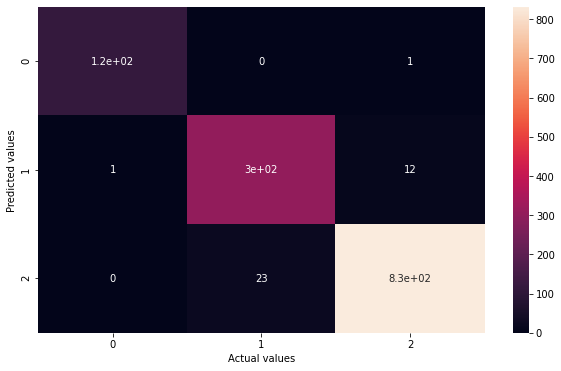

In [67]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(conf_matrix,annot=True)
plt.xlabel('Actual values')
plt.ylabel('Predicted values')